In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

In [75]:
import seaborn as sns

In [ ]:
sns.pairplot()

In [2]:
# load data
df = pd.read_csv('../data/churn_data.csv')
df.shape

(3333, 21)

In [3]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
# remove unique identifiers 
df.pop('phone number')
df.pop('area code')
df.columns

Index(['state', 'account length', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn'],
      dtype='object')

In [5]:
# check column types
df.dtypes

state                      object
account length              int64
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

In [6]:
df['international plan'].unique()

array(['no', 'yes'], dtype=object)

In [7]:
# this function takes a dataframe and a column name within that dataframe and converts values to int's 0 and 1
# inputs: data (dataframe), column (string)
# output: data[column] as column of 0's and 1's
# note, operations NOT done inplace

def convert_to_binary(data, column, yes_list=['yes', 'Yes', 'YES', '1']):
    
    if len(data[column].unique()) <= 2:
        
        if data[column].dtype == bool:
            data[column] = data[column].astype(int)
            return data[column]
        
        elif data[column].dtype == object or data[column].dtype == str:
            yes_list = ['yes', 'Yes', 'YES', '1']

            for yes in yes_list:
                if yes in data[column].unique():
                    data[column] = data[column].eq(yes).mul(1)
                    return data[column]
                
                else:
                    return print('Entries could not be converted binary. Check entries or try custom list for keyword argument "yes_list".')
                
        else:
            return print("Entries could not be converted binary, confirm check for NA's or consider OneHotEncoding.")
        
    else:
        return print("Entries could not be converted binary, more than 2 entry types.")

binary_column_list = ['international plan', 'voice mail plan', 'churn']

for column in binary_column_list:
    print(column)
    df[column] = convert_to_binary(df, column)

international plan
voice mail plan
churn


In [8]:
df['churn'].head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int32

In [9]:
df['international plan'].head()

0    0
1    0
2    0
3    1
4    1
Name: international plan, dtype: int32

In [10]:
# Code below replaced with function "convert_to_binary"
# # clean data
# # convert binaries
# churn_dict = {False: 0, True: 1}
# yes_no_dict = {'no': 0, 'yes': 1}
# df['churn'].replace(churn_dict, inplace=True)
# df['international plan'].replace(yes_no_dict, inplace=True)
# df['voice mail plan'].replace(yes_no_dict, inplace=True)
# df.head()

In [71]:
left.churn.sum()

137

In [73]:
df.churn.sum()

483

In [74]:
137/483

0.2836438923395445

In [11]:
# split data into target and predictors
y = df.churn
X = df.drop('churn', axis=1)
X.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [12]:
len(X.state.unique().sum())/2

51.0

In [13]:
# from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [14]:
# ohe_column_list = ['state']
# X_train_cat = X[ohe_column_list]
# X_train_cat.head()

In [15]:
# X_train_num = X.drop(ohe_column_list, axis=1)
# X_train_num.head()

In [16]:
# # This code will onehotencode the categorical columns and return the dataframe
# # inputs: X (dataframe), column_list (list of categorical columns)
# # returns: X_ohe (one-hot-encoded dataframe)
# # note, operations NOT done inplace

# def ohe2021(X, column_list):  
#     # One hot encode
#     valid_columns = []
    
#     # remove columns not in X dataframe
#     for column in column_list:
#         if column in X.columns:
#             valid_columns.append(column)
        
#         else:
#             print(f'Column "{column}" not found in DataFrame')
            
#     # get dataframe of categroical columns to oneHotEncode
#     X_cat = X[valid_columns]
#     X_cat.head()

#     # get dataframe of numeric columns to oneHotEncode
#     X_num = X.drop(valid_columns, axis=1)
#     X_num.head()

#     # Finally, One Hot Encode
#     # from sklearn.preprocessing import OneHotEncoder
#     ohe = OneHotEncoder(sparse=False, drop='first')
#     X_cat_oh = pd.DataFrame(ohe.fit_transform(X_cat), index= X_cat.index, columns=ohe.get_feature_names(X_cat.columns))
#     X_cat_oh.head()

#     # sandwich OHE df with numerical dataframes
#     X_ohe = X_num.join(X_cat_oh)
#     return X_ohe

# ohe_column_list = ['state', 'area code']
# X_train_ohe = ohe2021(X_train, ohe_column_list)
# X_train_ohe.head()

In [17]:
X_train.shape

(2666, 18)

In [18]:
y_train.shape

(2666,)

In [19]:
# # scale data
# # function scales dataframe using StandardScaler
# # inputs: X (dataframe) 
# # returns: X_scaled (dataframe) 
# # note, operations NOT done inplace

# def scale2021(X):
#     ss = StandardScaler()
#     X_scaled = pd.DataFrame(ss.fit_transform(X))
#     X_scaled.index = X.index
#     X_scaled.columns = X.columns
#     return X_scaled

# X_train_scaled = scale2021(X_train_ohe)
# X_train_scaled.head()

In [20]:
# X_train_resamp, y_train_resamp = SMOTE().fit_resample(X_train_scaled, y_train)

In [21]:
# X_train_resamp.shape

In [22]:
# y_train_resamp.sum()

In [23]:
# # FSM
# logreg = LogisticRegression()
# logreg.fit(X_train_resamp, y_train_resamp)
# logreg.score(X_train_scaled, y_train)

In [24]:
my_column_trans = make_column_transformer((OneHotEncoder(), ['state']))

In [25]:
# smoted_scaled_pipeline = Pipeline([('col_transformer', OneHotEncoder(dtype=object)),
#                                    ('ss', StandardScaler()),
#                                    ('smote', SMOTE()),
#                                    ('logreg', LogisticRegression())])

In [26]:
preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
                                       (StandardScaler(), make_column_selector(dtype_include=np.number),
                                        SMOTE()))
#preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
                                                # StandardScaler(),
                                                # SMOTE(),
                                                # LogisticRegression())
preprocessing

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5636C1EB0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5636C1100>)])

In [27]:
# preprocessing_test = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)), 
#                                             (StandardScaler(), make_column_selector(dtype_include=np.number)))

In [28]:
X_train.shape

(2666, 18)

In [29]:
X_test.shape

(667, 18)

In [30]:
preprocessing.fit_transform(X_train)

<2666x68 sparse matrix of type '<class 'numpy.float64'>'
	with 47988 stored elements in Compressed Sparse Row format>

In [31]:
dt_pipeline = make_pipeline(preprocessing, DecisionTreeClassifier(random_state=2021))
rf_pipeline = make_pipeline(preprocessing, RandomForestClassifier(random_state=2021))

In [32]:
cross_val_score(dt_pipeline, X_train, y_train, scoring='f1')

array([0.67924528, 0.66257669, 0.70666667, 0.74390244, 0.75816993])

In [33]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5636C1EB0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002C5636C1100>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=2021))])

In [34]:
# y_pred = dt_pipeline.predict(X_train)

In [35]:
%matplotlib inline

In [36]:
cmap_list_uniform = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

In [38]:
# title = ' '.join([prepend_title, title, append_title])
colors = ['flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar', 'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'twilight', 'twilight_shifted', 'hsv', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink','spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia','hot', 'afmhot', 'gist_heat', 'copper','PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic','viridis', 'plasma', 'inferno', 'magma', 'cividis']

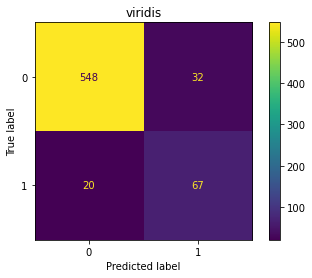

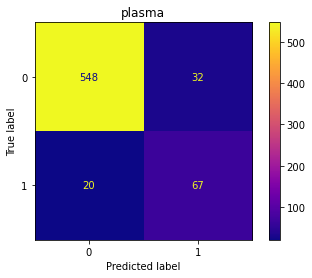

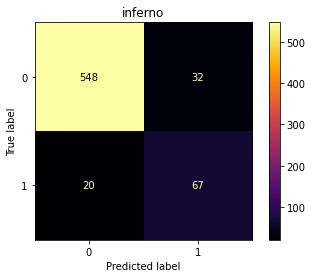

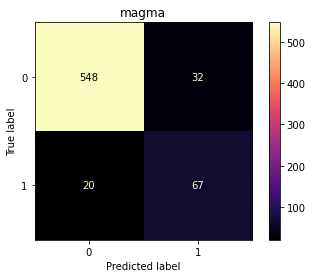

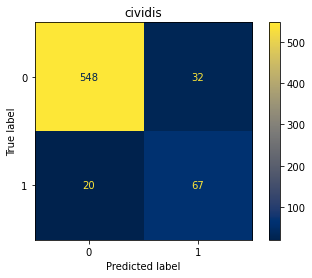

In [39]:
for cmap in cmap_list_uniform:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

In [40]:
cmaps_list_diverging = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

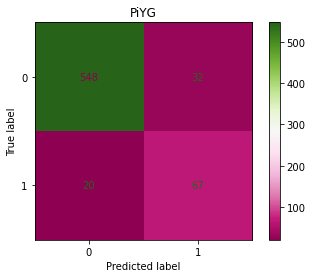

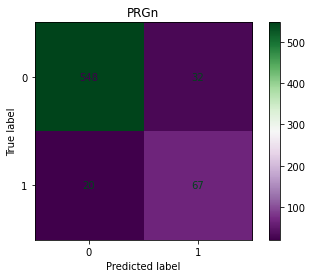

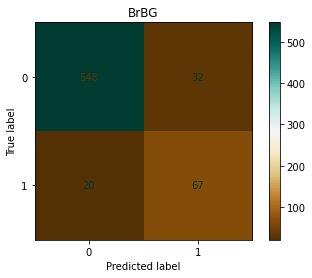

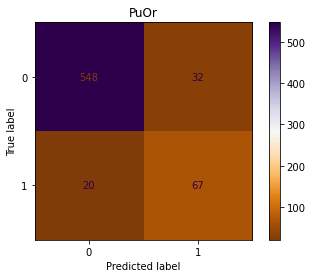

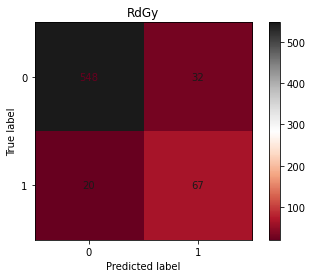

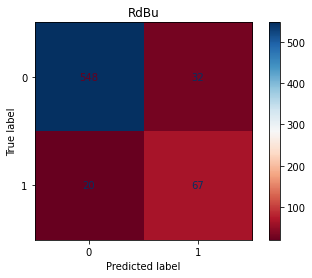

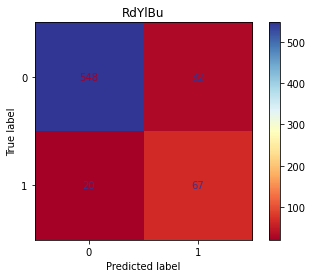

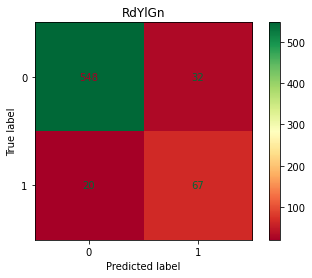

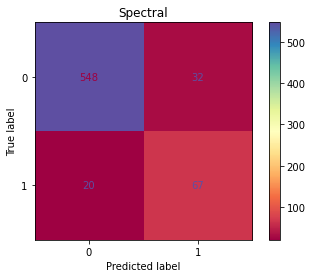

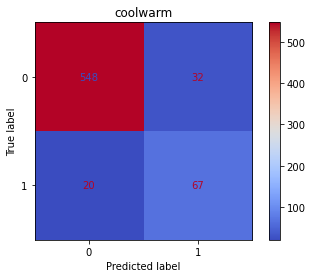

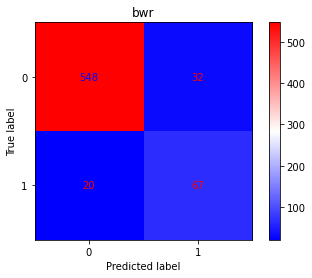

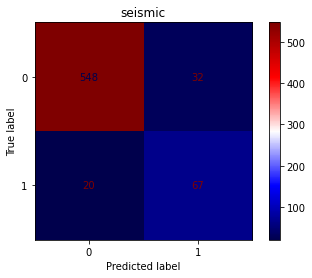

In [41]:
for cmap in cmaps_list_diverging:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

In [42]:
cmaps_list_seq2 = ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

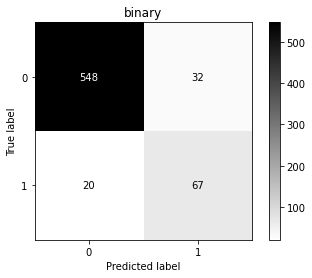

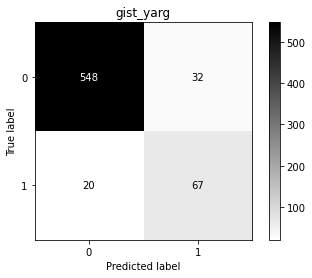

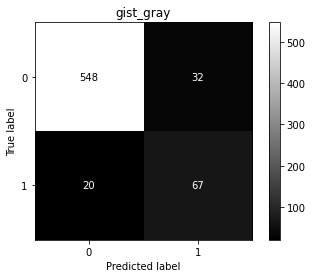

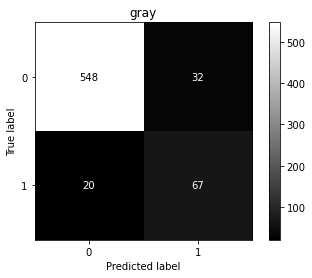

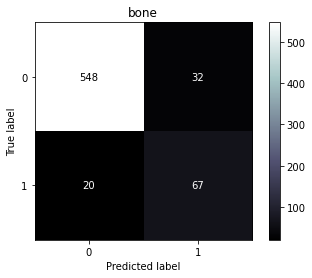

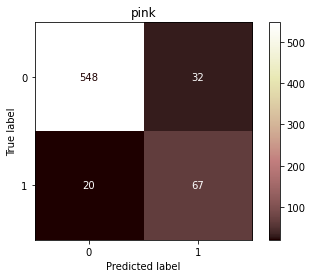

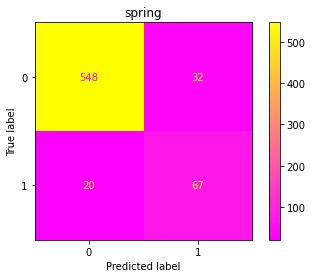

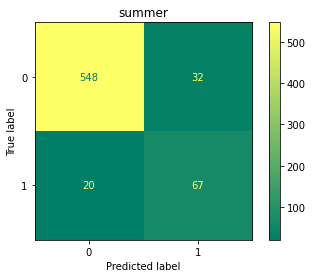

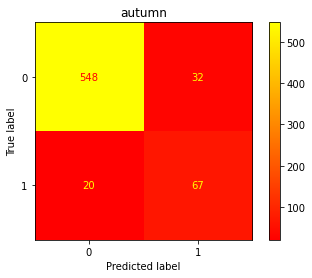

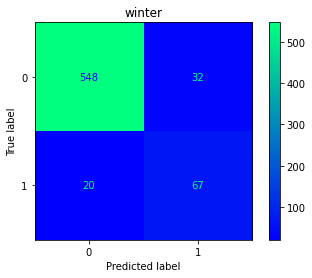

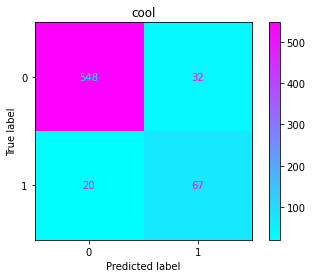

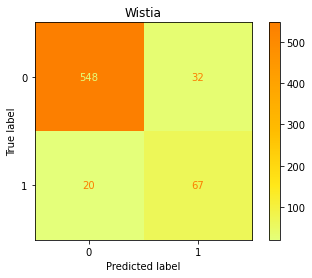

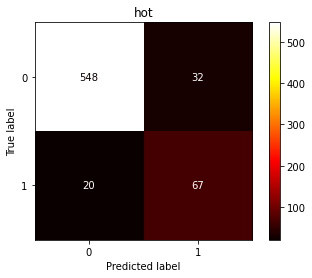

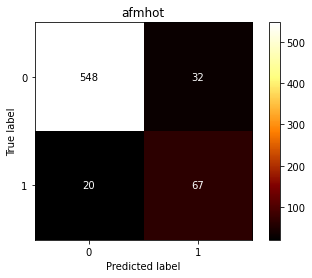

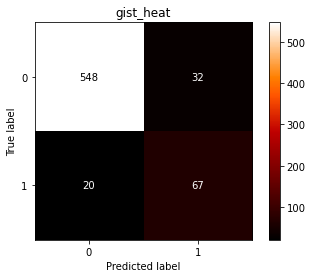

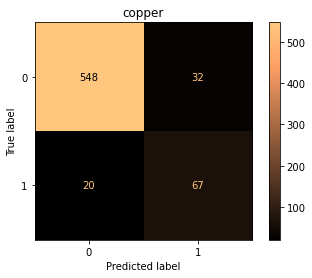

In [43]:
for cmap in cmaps_list_seq2:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

In [44]:
cmaps_cyc = ['twilight', 'twilight_shifted', 'hsv']

In [45]:
cmaps_qual = ['Pastel1', 'Pastel2', 'Paired', 'Accent',\
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

In [46]:
cmaps_misc = [\
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

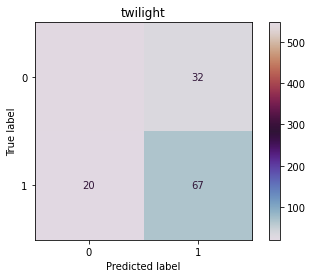

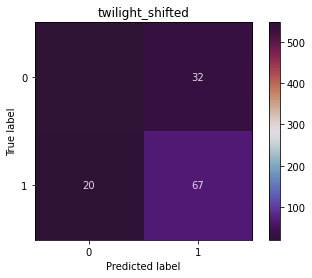

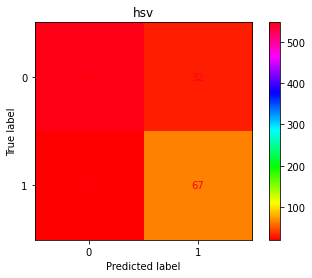

In [47]:
for cmap in cmaps_cyc:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

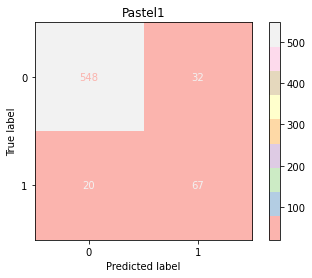

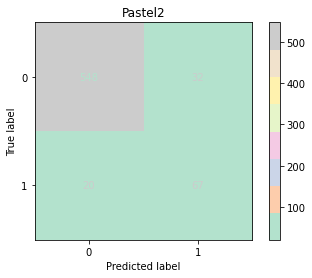

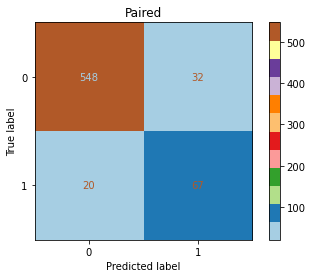

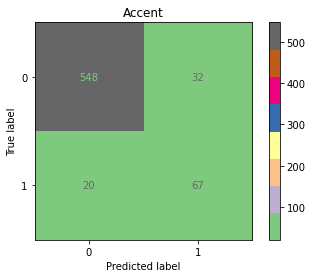

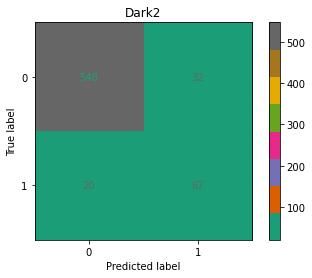

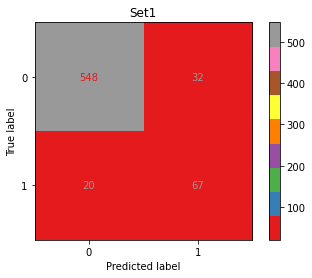

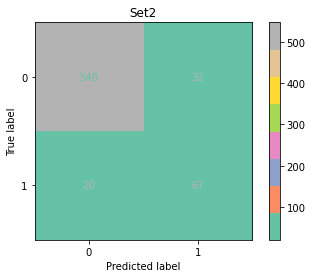

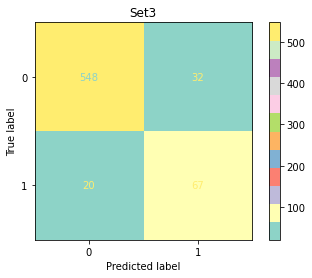

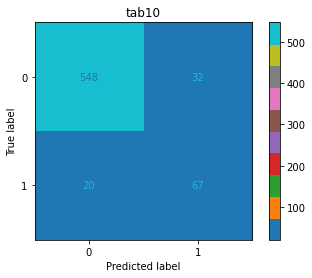

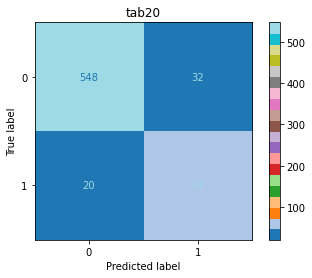

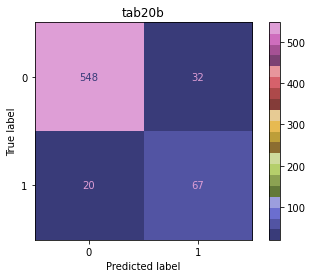

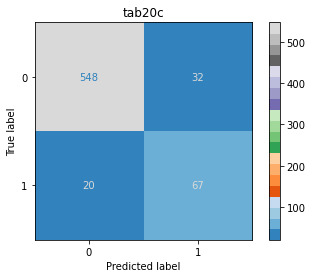

In [48]:
for cmap in cmaps_qual:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

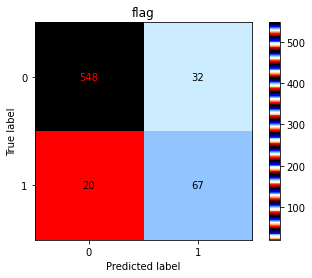

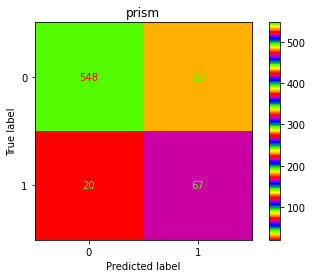

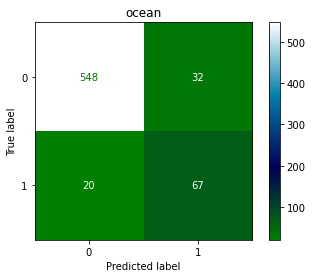

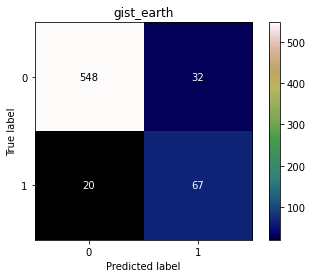

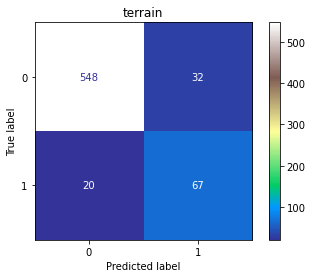

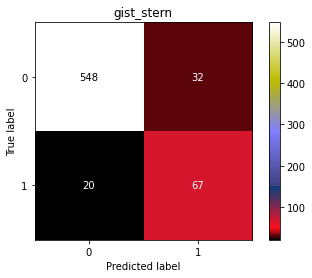

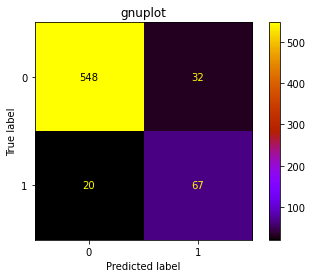

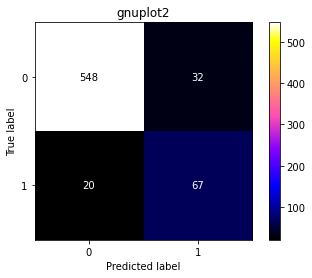

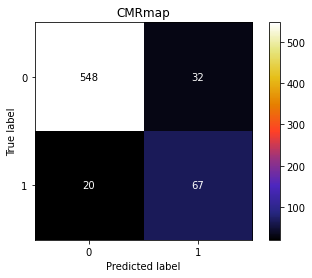

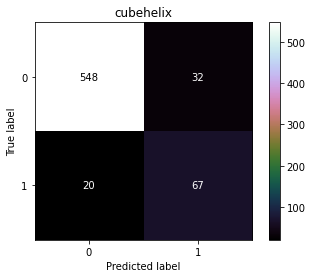

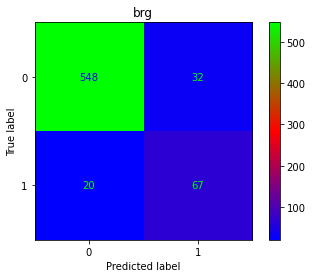

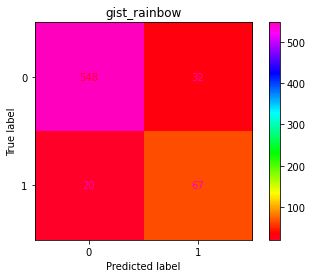

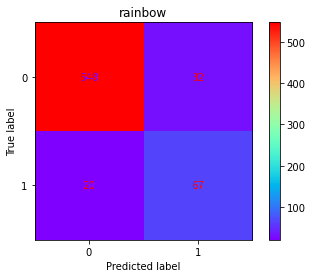

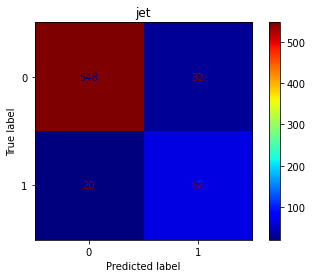

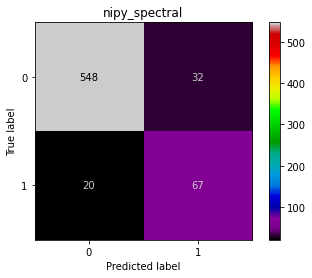

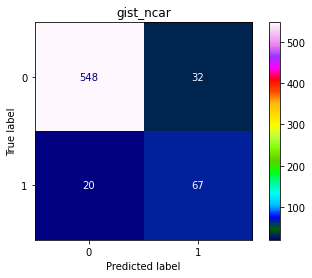

In [49]:
for cmap in cmaps_misc:
    plot_confusion_matrix(dt_pipeline, X_test, y_test, cmap=cmap)
    plt.title(cmap)
    plt.show()

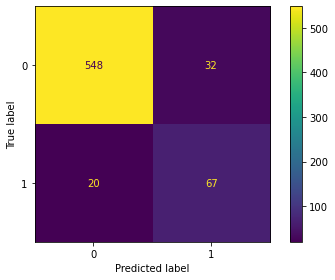

In [50]:
cm_dt_test = plot_confusion_matrix(dt_pipeline, X_test, y_test)
plt.tight_layout()
plt.savefig('dt_confusion_matrix.png', transparent=True)

In [51]:
# Filter data
# create list of columns with correlations greater than a given percentage
#    function takes data (data) and returns list of columns (strong_corrs)
#    this list has correlations higher than min_percent (min_percent) to specified column (column)

# Inputs: data (pandas dataframe), column (name of column in dataframe), kwarg-- min_percent (float)
# Returns: strong corrs (list)

def find_corr(data, column, min_percent=0.1):
    corr = data.corr()
    strong_corrs = []
    for key, value in dict(corr[column]).items():
        if abs(value) > min_percent:
            strong_corrs.append(key)
    print(strong_corrs)
    return strong_corrs

find_corr(df, 'churn')

['international plan', 'voice mail plan', 'total day minutes', 'total day charge', 'customer service calls', 'churn']


['international plan',
 'voice mail plan',
 'total day minutes',
 'total day charge',
 'customer service calls',
 'churn']

In [52]:
logreg_coeff_dict = {'account length': 0.05465803660831661,
 'international plan': 0.8643214342535465,
 'voice mail plan': -1.0711561540621855,
 'number vmail messages': 0.5833956886122196,
 'total day minutes': 0.4340366106210175,
 'total day calls': 0.13459785202522626,
 'total day charge': 0.4364428169395637,
 'total eve minutes': 0.2441232588375694,
 'total eve calls': 0.04343982996400333,
 'total eve charge': 0.19552916020418074,
 'total night minutes': 0.061636974815759776,
 'total night calls': -0.0330775687848651,
 'total night charge': 0.120504044650966,
 'total intl minutes': 0.08417780777778124,
 'total intl calls': -0.20176042838853372,
 'total intl charge': 0.11572075198029565,
 'customer service calls': 0.9224756204837488,
 'state_AL': -0.19695803241769763,
 'state_AR': -0.11870998456433077,
 'state_AZ': -0.21820736138398855,
 'state_CA': -0.007653722948586534,
 'state_CO': -0.09376945413983571,
 'state_CT': -0.06862379551398427,
 'state_DC': -0.035934708182815016,
 'state_DE': -0.11591257634456187,
 'state_FL': -0.11225533552254204,
 'state_GA': -0.1230770826771515,
 'state_HI': -0.28822980460679276,
 'state_IA': -0.2189503869421113,
 'state_ID': -0.052067678745411315,
 'state_IL': -0.47615808272561627,
 'state_IN': -0.14404718938587366,
 'state_KS': -0.13275662680565922,
 'state_KY': -0.1383619140270367,
 'state_LA': -0.19767580382468383,
 'state_MA': 0.006359173088373753,
 'state_MD': -0.09561780694437244,
 'state_ME': -0.031344145195332525,
 'state_MI': -0.04475111931445505,
 'state_MN': -0.08997110722518718,
 'state_MO': -0.23516580824963118,
 'state_MS': 0.0339091953344427,
 'state_MT': 0.1160445716571879,
 'state_NC': -0.15041799867841998,
 'state_ND': -0.11502698355669273,
 'state_NE': -0.15855667890530148,
 'state_NH': 0.018037306775368196,
 'state_NJ': -0.01940820240327665,
 'state_NM': -0.16910881816476933,
 'state_NV': -0.06070982105563326,
 'state_NY': -0.026700613399044833,
 'state_OH': -0.09748790609468524,
 'state_OK': -0.13997992585447655,
 'state_OR': -0.1252720049780493,
 'state_PA': -0.0693855249780221,
 'state_RI': -0.3250245767917228,
 'state_SC': 0.037861537667070455,
 'state_SD': -0.07221316067317722,
 'state_TN': -0.19516134807960445,
 'state_TX': -0.06943674298205064,
 'state_UT': -0.07900381481399842,
 'state_VA': -0.4457724438516671,
 'state_VT': -0.16534082081602763,
 'state_WA': -0.05619879421749988,
 'state_WI': -0.15079131101957885,
 'state_WV': -0.18138335316453594,
 'state_WY': -0.1323141577097756}

In [53]:
def create_plot_of_feature_importances(coeff_dict, top_num=10, title='Feature Importances', append_title='', prepend_title=''):
    ''' 
    Inputs: 
    
    model: A trained ensemble model instance
    X: a dataframe of the features used to train the model
    '''
    dict_keys = [key for key in coeff_dict.keys()]
    dict_values = [abs(value) for value in coeff_dict.values()]
    
    coeff_dict = {dict_keys[x]: dict_values[x] for x in range(len(dict_values))}
    coeff_dict = dict(list(coeff_dict.items())[:top_num])
    features_and_importances = zip(coeff_dict.keys(), coeff_dict.values())
    features_and_importances = sorted(features_and_importances, key = lambda x: x[1], reverse=True)
    
    features = [i[0] for i in features_and_importances]
    importances = [abs(i[1]) for i in features_and_importances]
    
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.gca().invert_yaxis()
    title = ' '.join([prepend_title, title, append_title])
    plt.title(title)
    plt.xlabel('importance')
    plt.tight_layout()

In [54]:
! mkdir images

A subdirectory or file images already exists.


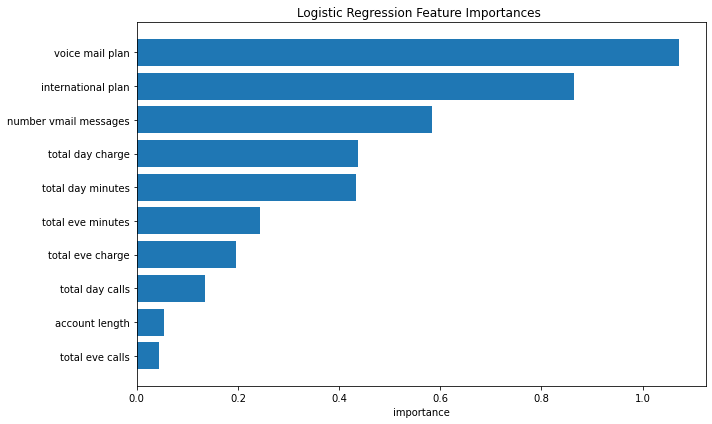

In [55]:
create_plot_of_feature_importances(logreg_coeff_dict, prepend_title='Logistic Regression')
plt.savefig('images/extra_trees_confusion_matrix.png', transparent=True)

In [56]:
logreg_coeff_dict

{'account length': 0.05465803660831661,
 'international plan': 0.8643214342535465,
 'voice mail plan': -1.0711561540621855,
 'number vmail messages': 0.5833956886122196,
 'total day minutes': 0.4340366106210175,
 'total day calls': 0.13459785202522626,
 'total day charge': 0.4364428169395637,
 'total eve minutes': 0.2441232588375694,
 'total eve calls': 0.04343982996400333,
 'total eve charge': 0.19552916020418074,
 'total night minutes': 0.061636974815759776,
 'total night calls': -0.0330775687848651,
 'total night charge': 0.120504044650966,
 'total intl minutes': 0.08417780777778124,
 'total intl calls': -0.20176042838853372,
 'total intl charge': 0.11572075198029565,
 'customer service calls': 0.9224756204837488,
 'state_AL': -0.19695803241769763,
 'state_AR': -0.11870998456433077,
 'state_AZ': -0.21820736138398855,
 'state_CA': -0.007653722948586534,
 'state_CO': -0.09376945413983571,
 'state_CT': -0.06862379551398427,
 'state_DC': -0.035934708182815016,
 'state_DE': -0.1159125763

In [57]:
# Filter data
# create list of columns with correlations greater than a given percentage
min_percent = 0.12
corr = df.corr()
strong_corrs = {}
for key, value in dict(corr.churn).items():
    if abs(value) > min_percent:
        strong_corrs[key]=value
print(strong_corrs)

{'international plan': 0.25985184734548417, 'total day minutes': 0.20515082926138778, 'total day charge': 0.20515074317015172, 'customer service calls': 0.20874999878379205, 'churn': 1.0}


In [58]:
from matplotlib.ticker import PercentFormatter

In [59]:
def create_plot_of_feature_importances(coeff_dict, top_num=10, figsize=(7, 6), title='Feature Importances', xlabel='Feature', ylabel='Correlation Percentage', append_title='', prepend_title='', width=0.8, xrot=0, bar_colors=None, percent=None):
    ''' 
    Inputs: 
    
    model: A trained ensemble model instance
    X: a dataframe of the features used to train the model
    '''
    dict_keys = [key for key in coeff_dict.keys()]
    dict_values = [abs(value) for value in coeff_dict.values()]
    
    coeff_dict = {dict_keys[x]: dict_values[x] for x in range(len(dict_values))}
    coeff_dict = dict(list(coeff_dict.items())[:])
    features_and_importances = zip(coeff_dict.keys(), coeff_dict.values())
    features_and_importances = sorted(features_and_importances, key = lambda x: x[1], reverse=True)
    
    features = [i[0].title() for i in features_and_importances[1:top_num+1]]
    print(features)
    importances = [abs(i[1])*100 for i in features_and_importances[1:top_num+1]]
    print(importances)
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=figsize)
#     width = .35
    plt.bar(features, importances, width=width, color=bar_colors)
    if percent:
        ax.yaxis.set_major_formatter(PercentFormatter())
#     plt.gca().invert_yaxis()
    title = ' '.join([prepend_title, title, append_title])
    plt.title(title)
    plt.xlabel('Feature', fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.xticks(rotation=xrot)
    plt.axis('tight')
    plt.tight_layout()

['International Plan', 'Customer Service Calls', 'Total Day Minutes']
[25.985184734548415, 20.874999878379207, 20.515082926138778]


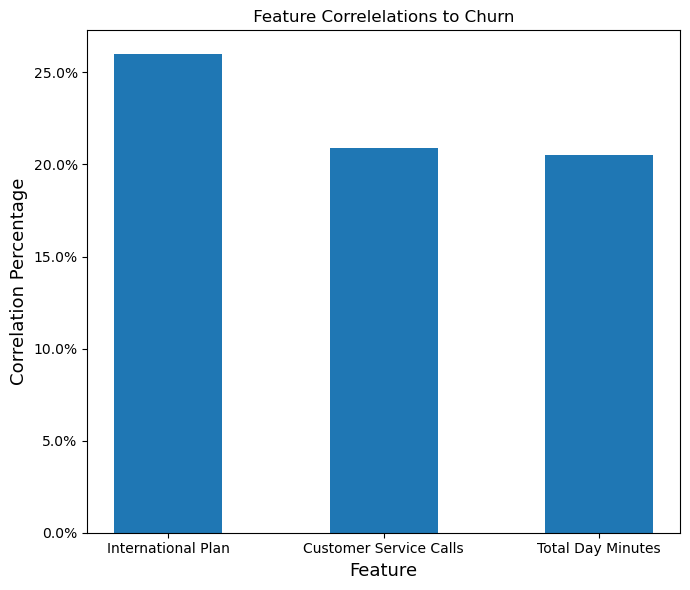

In [60]:
min_percent = 0.12
corr = df.corr().churn
corr=dict(corr)
create_plot_of_feature_importances(corr, title='Feature Correlelations to Churn', top_num=3, width=0.5, percent=True)
plt.savefig('images/Feature_corr.png', transparent=True)

In [76]:
df.corr().churn

account length            0.016541
international plan        0.259852
voice mail plan          -0.102148
number vmail messages    -0.089728
total day minutes         0.205151
total day calls           0.018459
total day charge          0.205151
total eve minutes         0.092796
total eve calls           0.009233
total eve charge          0.092786
total night minutes       0.035493
total night calls         0.006141
total night charge        0.035496
total intl minutes        0.068239
total intl calls         -0.052844
total intl charge         0.068259
customer service calls    0.208750
churn                     1.000000
Name: churn, dtype: float64

In [84]:
intl_plan.churn.sum()

137

In [78]:
df.churn.sum()

483

In [79]:
137/483

0.2836438923395445

In [85]:
len(intl_plan)/len(df)

0.0969096909690969

In [86]:
intl_plan.shape

(323, 19)

In [82]:
df.shape

(3333, 19)

In [87]:
intl_plan.churn.sum()/len(intl_plan)

0.4241486068111455

In [61]:
top_17 = [('total intl calls', 0.007662110949917248),
 ('total intl charge', 0.0033470091004430204),
 ('total day charge', 0.003259961859933837),
 ('total eve minutes', 0.003162403246382117),
 ('total night calls', 0.00277449674239552),
 ('account length', 0.002581535009061759),
 ('international plan', 0.002109226781666918),
 ('voice mail plan', 0.002103748904989105),
 ('total intl minutes', 0.0018711680184347753),
 ('total eve charge', 0.0017474977005077679),
 ('total day calls', 0.0017101284391014342),
 ('total night charge', 0.001615454532337387),
 ('number vmail messages', 0.0015464521017542058),
 ('customer service calls', 0.0012120735471571925),
 ('total eve calls', 0.001163035733859368),
 ('total night minutes', 0.000949022695754378),
 ('total day minutes', 0.0009380786304271744)]

['Total Intl Charge', 'Total Day Charge', 'Total Eve Minutes', 'Total Night Calls', 'Account Length']
[0.334700910044302, 0.3259961859933837, 0.31624032463821167, 0.277449674239552, 0.2581535009061759]


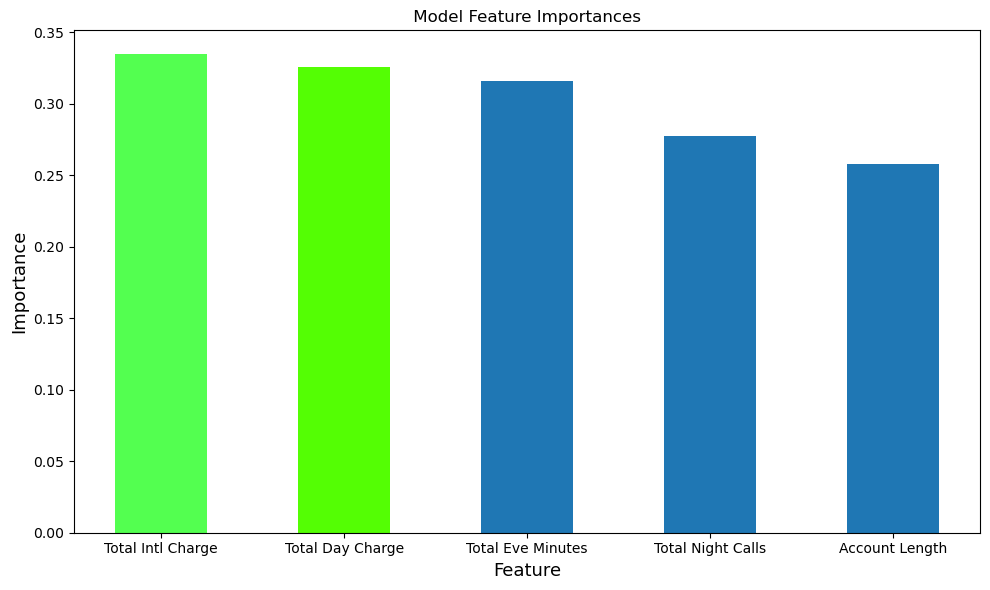

In [68]:
create_plot_of_feature_importances(dict(top_17), figsize=(10, 6), bar_colors=['#53FF50', '#54FE04', '#1F77B4', '#1F77B4', '#1F77B4','#54FE00'], top_num=5, width=0.5, title='Model Feature Importances', ylabel='Importance')
plt.savefig('images/Feature_importance.png', transparent=True)

['Total Intl Charge', 'Total Day Charge', 'Total Eve Minutes', 'Total Night Calls', 'Account Length', 'International Plan', 'Voice Mail Plan', 'Total Intl Minutes', 'Total Eve Charge', 'Total Day Calls']
[0.334700910044302, 0.3259961859933837, 0.31624032463821167, 0.277449674239552, 0.2581535009061759, 0.2109226781666918, 0.21037489049891048, 0.18711680184347754, 0.1747497700507768, 0.17101284391014343]


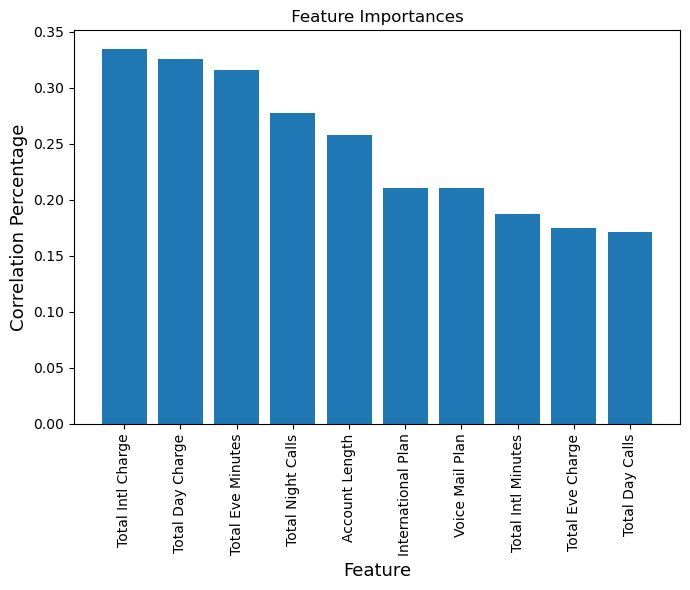

In [63]:
create_plot_of_feature_importances(dict(top_17), xrot=90)
